# Benchmark to find threshold for filtering low-variance features

See https://git.bia-christian.de/bia/lab_book_VEO/wiki/feature-selection#remove-low-variance-features

In [1]:
#Turn off scientific notation
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})

#Activate print all activities
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import input

In [97]:
import pickle
import zstandard
import pandas as pd
import numpy as np
import datetime

print("Started script! Loading input file...", datetime.datetime.now())

#feature = 'kmer9Classification'
#feature = 'kmer9Regression'
#feature = 'gene-familiesClassification'
feature = 'gene-familiesRegression'
#feature = 'gene-families'
#feature = 'kmer9'

#abiotic_factor = 'salt'
#abiotic_factor = 'temperature'
abiotic_factor = 'pH'
#abiotic_factor = 'oxygen'

#group = 'Salinity group'
#group = 'Salt all mean'
#group = 'Temp group'
#group = 'Temp all mean'
group = 'pH all mean'
#group = 'Oxygen tolerance'

file1 = '/home/bia/Documents/bacterial_phenotypes/connecting_features_abFactors/df_' + abiotic_factor + '_' + feature + '_selected-filterNA.pickle.zst'  
print(file1)

with zstandard.open(file1, 'rb') as f:
	df = pickle.load(f)

print("Loaded input pickle zst file...", datetime.datetime.now())
df.head()
df.shape

Started script! Loading input file... 2024-10-08 15:18:34.846572
/home/bia/Documents/bacterial_phenotypes/connecting_features_abFactors/df_pH_gene-familiesRegression_selected-filterNA.pickle.zst
Loaded input pickle zst file... 2024-10-08 15:18:34.979450


,COG3696@2,COG0606@2,33SZW@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,2Z7XP@2,COG1086@2,...,arCOG06650@2157,"Viruses,4R0IQ@35237",arCOG09713@2157,arCOG07735@2157,arCOG07334@2157,arCOG04203@2157,arCOG01811@2157,arCOG00087@2157,arCOG07496@2157,pH all mean
Best assembly,,,,,,,,,,,,,,,,,,,,,
1121349.4,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.500
1121394.3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.250
1121909.4,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.750
1123508.3,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5.500
1218801.3,1,1,0,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,7.500


(3630, 20142)

## Profiles of zero-variance gene families 

# Understand the global variances of the features

This block is meant for a global understanding of variances of different feature-types: kmers and gene-families.

# SKIP to next block for creating files with different variance filters

In [45]:
#Investigate the variance distribution of the current feature type

print("Shape of the input dataframe:", df.shape)
print()

#Separating features from group/target variable
X = df.drop(group, axis=1)
y = df[group]

#Calculate variance for each feature/column of all features
variances = X.var()

df_var = variances.to_frame()
df_var = df_var.rename(columns={0: 'Variance'})

# Normalize column of variances
df_var['Normalized variance'] = (df_var['Variance'] - df_var['Variance'].min()) / (df_var['Variance'].max() - df_var['Variance'].min())

df_var.head()

#Normalized Data
#normalized = (x-min(x))/(max(x)-min(x))

#type(df_var)
len(df_var)
#df_var.head()

df_var['Variance'].min()
df_var['Variance'].max() #Max could come from the abiotic factor!
df_var['Variance'].mean()
df_var['Variance'].median()

df_var['Normalized variance'].min()
df_var['Normalized variance'].max() #Max could come from the abiotic factor!
df_var['Normalized variance'].mean()
df_var['Normalized variance'].median()

#df['COG5009@2'].value_counts() #0.25
#df['33SZW@2'].value_counts() #0
#df['COG0480@2'].value_counts() #0.3

Shape of the input dataframe: (3630, 20142)



,Variance,Normalized variance
COG3696@2,0.24,0.96
COG0606@2,0.21,0.85
33SZW@2,0.00,0.00
COG0774@1,0.07,0.29
COG5009@2,0.25,0.99


20141

0.0

0.2500688135899438

0.00879640002176915

0.000275482093663912

0.0

1.0

0.035175917762353404

0.001101625147530952

In [34]:
#Only for the very first abiotic factor!
#df_all = df_var
#df_all = df_all.drop(columns=['Variance'])
#df_all = df_all.rename(columns={'Normalized variance': abiotic_factor})

#df_all.head()

,temperature
COG3696@2,0.90
COG0606@2,0.97
33SZW@2,0.00
COG0774@1,0.21
COG5009@2,1.00


In [46]:
df_var = df_var.rename(columns={'Normalized variance': abiotic_factor})
df_all[abiotic_factor] = df_var[abiotic_factor]
df_all.head()

,temperature,oxygen,salt,pH
COG3696@2,0.90,0.89,0.96,0.96
COG0606@2,0.97,0.94,0.86,0.85
33SZW@2,0.00,0.00,0.00,0.00
COG0774@1,0.21,0.25,0.30,0.29
COG5009@2,1.00,1.00,0.99,0.99


In [48]:
df_all.to_csv('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_boxplot_var_gene-families.csv', index=True)

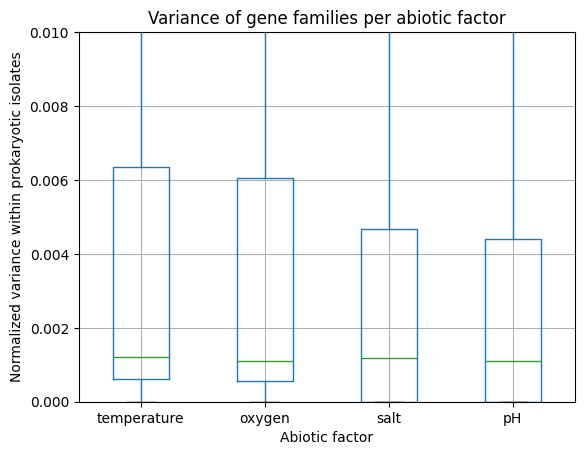

In [49]:
#from matplotlib.ticker import ScalarFormatter
import pandas as pd
import matplotlib.pyplot as plt

#Plot variance distribution

boxplot = df_all.boxplot()

#https://www.reddit.com/r/learnpython/comments/el4vbx/how_to_remove_scientific_notation_from_a/
#Remove scientific notation from y-axis
#plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

#Add axis labels and title
plt.xlabel('Abiotic factor');
plt.ylabel('Normalized variance within prokaryotic isolates');
#plt.title('Variance of kmers per abiotic factor');
plt.title('Variance of gene families per abiotic factor');

# Set y-axis limits
plt.ylim(0, 0.01), 

plt.savefig('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/boxplot_variances_gene-families.png', dpi=300)
#plt.savefig('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/boxplot_variances_kmer9.png', dpi=300)

# Show the plot
plt.show();

# Create files for filtering low-variance features with different thresholds

In [4]:
#CLASSIFICATION #########################################
#STEP NECESSARY BEFORE CREATING FILES ###################

df[group].unique()

#Oxygen
#Replace string to int for target variable
#df[group] = df[group].replace(['anaerobe'], 0)
#df[group] = df[group].replace(['facultative'], 2)
#df[group] = df[group].replace(['aerobe'], 1)

#Salt, temperature
#Replace string to int for target variable
df[group] = df[group].replace(['low'], 0)
df[group] = df[group].replace(['medium'], 2)
df[group] = df[group].replace(['high'], 1)

#df = df[df[group] != 2]
#IF I CONTINUE WITH THIS STRATEGY, I SHOULD ALSO DO THE UNDERSAMPLING AT THIS POINT

#MAKE SURE THE NUMBER OF GROUPS IS CORRECT AND ADAPT CODE IF NECESSARY
print('Number of isolates with group low/anaerobe:', len(df[df[group] == 0]) )
print('Number of isolates with group medium/facultative:', len(df[df[group] == 2]) )
print('Number of isolates with group high:/aerobe', len(df[df[group] == 1]) )

df.shape
df.head()

array(['medium', 'high', 'low'], dtype=object)

/tmp/ipykernel_14043/1778442278.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[group] = df[group].replace(['high'], 1)


Number of isolates with group low/anaerobe: 466
Number of isolates with group medium/facultative: 1429
Number of isolates with group high:/aerobe 1523


(3418, 20142)

,COG3696@2,COG0606@2,33SZW@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,2Z7XP@2,COG1086@2,...,arCOG06650@2157,"Viruses,4R0IQ@35237",arCOG09713@2157,arCOG07735@2157,arCOG07334@2157,arCOG04203@2157,arCOG01811@2157,arCOG00087@2157,arCOG07496@2157,Salinity group
Best assembly,,,,,,,,,,,,,,,,,,,,,
1121349.4,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1121909.4,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1123508.3,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218801.3,1,1,0,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,2
1420583.3,1,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [17]:
#Change range for loop for kmers or gene-families
#For classification, remove group == 2 below!
#     #tmp = tmp[tmp[group] != 2]
#For regression, do NOT remove this group

#Create files with different thresholds

print("Shape of the input dataframe:", df.shape)
print()

#Separating features from group/target variable
X = df.drop(group, axis=1)
y = df[group]

#Calculate variance for each feature/column of all features
variances = X.var()

# Normalize column of variances
variances = ( variances - variances.min()) / (variances.max() - variances.min() )


#Initialize list of percentages of low-variance features to be filtered out
values = []        

#Identify columns with different variances
#for i in np.arange(0, 0.017, 0.001): # Specific for gene-familiesRegression, pH, to get more thresholds, since the plot was inconclusive
#for i in np.arange(0, 0.011, 0.001): #Gene families
for i in np.arange(0, 0.0021, 0.0002): #kmers
    
    tmp = X.copy()

    #Get list of columns with variance smaller or equal to i
    zero_variance_columns = variances[variances <= i].index
    #print(zero_variance_columns)

    #Add to list the percentage of low-variance features to be filtered out
    percentage = str( round( (len(zero_variance_columns)/len(tmp.columns))*100, 1) )
    values.append(percentage)
    
    print(" Threshold:", i, "Number of zero-variance features:", len(zero_variance_columns), ',', percentage)

    #Drop low-variance features
    tmp = tmp.drop(columns=zero_variance_columns)

    tmp[group] = y
    
    #Remove intermediate group to keep only extremes for benchmarking below
    #NOTE THAT THE LOW-VARIANCE FEATURES WERE REMOVED BEFORE REMOVING INTERMEDIATE GROUP!
    #Removal of the intermediate group is only done for benchmarking reasons!
#    tmp = tmp[tmp[group] != 2]
    
    #tmp.head()

    print(" Shape of dataframe without zero-variance features:", tmp.shape, " Any NAs in the dataframe?", tmp.isnull().any().any())
    
    #with zstandard.open('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + feature + '_' + str(i) + '.pickle.zst', 'wb') as f:
    #    pickle.dump(tmp, f)

Shape of the input dataframe: (13198, 131073)

 Threshold: 0.0 Number of zero-variance features: 1 , 0.0
 Shape of dataframe without zero-variance features: (13198, 131072)  Any NAs in the dataframe? False
 Threshold: 0.0002 Number of zero-variance features: 49022 , 37.4
 Shape of dataframe without zero-variance features: (13198, 82051)  Any NAs in the dataframe? False
 Threshold: 0.0004 Number of zero-variance features: 74059 , 56.5
 Shape of dataframe without zero-variance features: (13198, 57014)  Any NAs in the dataframe? False
 Threshold: 0.0006000000000000001 Number of zero-variance features: 86892 , 66.3
 Shape of dataframe without zero-variance features: (13198, 44181)  Any NAs in the dataframe? False
 Threshold: 0.0008 Number of zero-variance features: 94774 , 72.3
 Shape of dataframe without zero-variance features: (13198, 36299)  Any NAs in the dataframe? False
 Threshold: 0.001 Number of zero-variance features: 99993 , 76.3
 Shape of dataframe without zero-variance features

## Benchmark

In [171]:
#Importing packages
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sys

In [25]:
#REGRESSION #########################################

#See remove_zero_variance_py

In [9]:
#CLASSIFICATION #########################################
#CHANGE RANGE BELOW TO FIT GENE FAMILIES OR KMERS

#Benchmark different thresholds of filtering low-variance features

#Cross-validation packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import statistics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

n_jobs = 5
f1_df = pd.DataFrame()

path = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_'

print("Started script on: ", datetime.datetime.now())

#Loop for different thresholds for filtering low-variance
#for i in np.arange(0, 0.011, 0.001):  
for i in np.arange(0, 0.0021, 0.0002):
        
    with zstandard.open(path + abiotic_factor + '_' + 
                        feature + '_' + str(i) + '.pickle.zst', 'rb') as f: 
        tmp = pickle.load(f)
    
    print('Calculating metrics for threshold', i, 'of filtering low-variance features...')
    print('  Shape of input data:', tmp.shape)
    
    list_means = []

    #Separating features from group/target variable
    X = tmp.drop(group, axis=1)
    y = tmp[group]

    #I included random_state to make this command reproducible for after feature selection
    #Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle=True, random_state = 99)
    
    #UNDERSAMPLING - important for classification problems and unbalanced groups
    #Definindo o RandomUnderSampler
    #I used a seed for the random state, which means that the undersampling will always choose the same samples,
    # which in my case is fine, since I am comparing different thresholds
    rus = RandomUnderSampler(random_state=5)
    
    # Aplicando para X e y
    X, y = rus.fit_resample(X_train, y_train)
    print('  Shape of training and undersampled data:', X.shape)
    
    #Do 10 iterations for every different threshold
    for it in range(1, 11, 1):
#    for it in range(1, 3, 1):        

        #Cross-validation with seed that changes with every iteration. The same split is desired per thresholds, since I want to
        # compare them. However within iterations, I want different splits
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=it)
        #I ran salt, gene-families without seed, and the results were extremely similar
    
        #Instantiate Random Forest model
        clf = RandomForestClassifier()

        scoring = ['f1']
        output = cross_validate(clf, X, y, cv=5, scoring = scoring, return_train_score=False, return_estimator =True, n_jobs=n_jobs)
        #print(output)
        #{'fit_time': array([0.68, 0.73, 0.72, 0.68, 0.61]), 'score_time': array([0.12, 0.11, 0.11, 0.19, 0.11]), 
        #'estimator': [RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier()], 
        #'test_f1': array([0.91, 0.90, 0.88, 0.75, 0.68])}
        
        #Get mean F1 for this iteration
        mean = statistics.mean(output['test_f1'])
        #Add mean F1 to vector containing results of all iterations
        list_means.append(mean)

        print(' Iteration', it, 'has as mean F1 value =', round(mean, 3), 'All values:', output['test_f1'])
    
    print(' Mean F1 score of cross-validation for all iterations:', round(statistics.mean(list_means), 3))
    print("Finished 10 iterations on: ", datetime.datetime.now())
    
    #Add new values
    f1_df[i] = list_means

#Save benchmark results to a CSV file
#f1_df.to_csv(path + 'f1_benchmark_' + abiotic_factor + '_' + feature + '.csv', index=True)

Started script on:  2024-07-29 10:36:33.709193
Calculating metrics for threshold 0.0 of filtering low-variance features...
  Shape of input data: (1989, 10987)
  Shape of training and undersampled data: (746, 10986)
 Iteration 1 has as mean F1 value = 0.865 All values: [0.88 0.87 0.87 0.84 0.86]
 Iteration 2 has as mean F1 value = 0.854 All values: [0.87 0.82 0.86 0.86 0.87]
 Iteration 3 has as mean F1 value = 0.84 All values: [0.86 0.84 0.82 0.85 0.83]
 Iteration 4 has as mean F1 value = 0.856 All values: [0.84 0.83 0.86 0.88 0.86]
 Iteration 5 has as mean F1 value = 0.849 All values: [0.86 0.84 0.86 0.83 0.85]
 Iteration 6 has as mean F1 value = 0.853 All values: [0.85 0.84 0.87 0.85 0.86]
 Iteration 7 has as mean F1 value = 0.843 All values: [0.84 0.83 0.84 0.85 0.84]
 Iteration 8 has as mean F1 value = 0.853 All values: [0.88 0.84 0.83 0.88 0.85]
 Iteration 9 has as mean F1 value = 0.866 All values: [0.88 0.86 0.85 0.86 0.88]
 Iteration 10 has as mean F1 value = 0.845 All values: [

FileNotFoundError: [Errno 2] No such file or directory: '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_salt_gene-familiesClassification_0.0002.pickle.zst'

In [172]:
#CLASSIFICATION #########################################
#Run just one file ######################################

#Benchmark different thresholds of filtering low-variance features

#Cross-validation packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import statistics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

n_jobs = 5
f1_df = pd.DataFrame()

path = '/home/bia/Documents/bacterial_phenotypes/connecting_features_abFactors/df_'

print("Started script on: ", datetime.datetime.now())

#                        df_pH               _gene-familiesRegression_selected-filterNA.pickle.zst        
with zstandard.open(path + abiotic_factor + '_' + feature + '_' + 'selected-filterNA.pickle.zst', 'rb') as f: 
        tmp = pickle.load(f)

print('File:', path + abiotic_factor + '_' + feature + '_' + 'selected-filterNA.pickle.zst')
print()

print('Calculating metrics for no filtering', 'of filtering low-variance features...')
print('  Shape of input data:', tmp.shape)
    
list_means = []

#Substitute group names for numbers ###############################################
#Oxygen
#tmp[group] = tmp[group].replace(['anaerobe'], 0)
#tmp[group] = tmp[group].replace(['facultative'], 2)
#tmp[group] = tmp[group].replace(['aerobe'], 1)

#Salt, temperature
tmp[group] = tmp[group].replace(['low'], 0)
tmp[group] = tmp[group].replace(['medium'], 2)
tmp[group] = tmp[group].replace(['high'], 1)

#Remove intermediary group
tmp = tmp[tmp[group] != 2]

#Separating features from group/target variable
X = tmp.drop(group, axis=1)
y = tmp[group]

#I included random_state to make this command reproducible for after feature selection
#Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle=True, random_state = 99)
    
#UNDERSAMPLING - important for classification problems and unbalanced groups
#Definindo o RandomUnderSampler
#I used a seed for the random state, which means that the undersampling will always choose the same samples,
# which in my case is fine, since I am comparing different thresholds
rus = RandomUnderSampler(random_state=5)
    
# Aplicando para X e y
X, y = rus.fit_resample(X_train, y_train)
print('  Shape of training and undersampled data:', X.shape)
    
#Do 10 iterations for every different threshold
for it in range(1, 11, 1):
#    for it in range(1, 3, 1):        

    #Cross-validation with seed that changes with every iteration. The same split is desired per thresholds, since I want to
    # compare them. However within iterations, I want different splits
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=it)
    #I ran salt, gene-families without seed, and the results were extremely similar
    
    #Instantiate Random Forest model
    clf = RandomForestClassifier()

    scoring = ['f1']
    output = cross_validate(clf, X, y, cv=5, scoring = scoring, return_train_score=False, return_estimator =True, n_jobs=n_jobs)
    #print(output)
    #{'fit_time': array([0.68, 0.73, 0.72, 0.68, 0.61]), 'score_time': array([0.12, 0.11, 0.11, 0.19, 0.11]), 
    #'estimator': [RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier()], 
    #'test_f1': array([0.91, 0.90, 0.88, 0.75, 0.68])}
        
    #Get mean F1 for this iteration
    mean = statistics.mean(output['test_f1'])
    #Add mean F1 to vector containing results of all iterations
    list_means.append(mean)

    print(' Iteration', it, 'has as mean F1 value =', mean, 'All values:', output['test_f1'])
    
print(' Mean F1 score of cross-validation for all iterations:', statistics.mean(list_means))
print("Finished 10 iterations on: ", datetime.datetime.now())
    
#Add new values
f1_df = list_means

print()
print('Dataframe:')
print(f1_df)

#Save benchmark results to a CSV file
#f1_df.to_csv(path + 'f1_benchmark_' + abiotic_factor + '_' + feature + '.csv', index=True)

Started script on:  2024-08-14 12:44:57.397932
File: /home/bia/Documents/bacterial_phenotypes/connecting_features_abFactors/df_temperature_kmer9Classification_selected-filterNA.pickle.zst

Calculating metrics for no filtering of filtering low-variance features...
  Shape of input data: (13198, 131073)


/tmp/ipykernel_4337/803352090.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tmp[group] = tmp[group].replace(['high'], 1)


  Shape of training and undersampled data: (534, 131072)
 Iteration 1 has as mean F1 value = 0.9542811917276105 All values: [0.93 0.96 0.92 0.98 0.97]
 Iteration 2 has as mean F1 value = 0.9558963690031651 All values: [0.94 0.96 0.93 0.97 0.97]
 Iteration 3 has as mean F1 value = 0.9520058618794651 All values: [0.93 0.95 0.92 0.98 0.97]
 Iteration 4 has as mean F1 value = 0.9559926469659105 All values: [0.93 0.97 0.93 0.98 0.96]
 Iteration 5 has as mean F1 value = 0.9562135343401227 All values: [0.94 0.96 0.93 0.98 0.96]
 Iteration 6 has as mean F1 value = 0.9479390322222989 All values: [0.92 0.96 0.91 0.97 0.97]
 Iteration 7 has as mean F1 value = 0.9562798388370838 All values: [0.93 0.97 0.93 0.98 0.97]
 Iteration 8 has as mean F1 value = 0.9580202199949406 All values: [0.95 0.97 0.91 0.98 0.97]
 Iteration 9 has as mean F1 value = 0.9560003140292571 All values: [0.93 0.97 0.92 0.98 0.97]
 Iteration 10 has as mean F1 value = 0.954167429932222 All values: [0.93 0.96 0.92 0.98 0.97]
 Me

# Understand specific variances

This block is more specific than the block above for "Understand the global variances...". Instead of understanding global variances of feature types, I mean to understand specifics, such as variance of a a specific COG or how a variance = 0 looks like.  

The two experiments I am doing here:

- get the profiles of zero variance of gene families
- get specific variances of top 50 most important features of SVC and RF of the Chrats experiment of classification of salinity groups

In [98]:
#To load file, go to the very top and select desired abiotic factor and feature type
#The input file to this code block is the unfiltered file containing all features 
df.head()

,COG3696@2,COG0606@2,33SZW@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,2Z7XP@2,COG1086@2,...,arCOG06650@2157,"Viruses,4R0IQ@35237",arCOG09713@2157,arCOG07735@2157,arCOG07334@2157,arCOG04203@2157,arCOG01811@2157,arCOG00087@2157,arCOG07496@2157,pH all mean
Best assembly,,,,,,,,,,,,,,,,,,,,,
1121349.4,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.500
1121394.3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.250
1121909.4,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.750
1123508.3,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5.500
1218801.3,1,1,0,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,7.500


## Calculate variances for every individual feature

In [99]:
#Calculate variances and normalized variances and put them into dataframes

print("Shape of the input dataframe:", df.shape)
print()

#Separating features from group/target variable
X = df.drop(group, axis=1)
y = df[group]

#Calculate variance for each feature/column of all features
variances = X.var()

print("Raw variances:")
print("Max var:", variances.max())
#type(variances)

#Convert the Series to a DataFrame
variances_df = variances.reset_index()
variances_df.columns = ['COGs', 'Variances']  # Rename columns for clarity
variances_df.head()

# Normalize column of variances
variances_normalized = ( variances - variances.min()) / (variances.max() - variances.min() )
#Convert the Series to a DataFrame
variances_norm_df = variances_normalized.reset_index()
variances_norm_df.columns = ['COGs', 'Normalized variances']  # Rename columns for clarity

print("Normalized variances:")
variances_norm_df.head()

Shape of the input dataframe: (3630, 20142)

Raw variances:
Max var: 0.2500688135899438


,COGs,Variances
0,COG3696@2,0.240
1,COG0606@2,0.214
2,33SZW@2,0.000
3,COG0774@1,0.072
4,COG5009@2,0.249


Normalized variances:


,COGs,Normalized variances
0,COG3696@2,0.961
1,COG0606@2,0.855
2,33SZW@2,0.001
3,COG0774@1,0.287
4,COG5009@2,0.995


In [100]:
#Investigate zero variance features

#Example: get original distribution of gene family for a COG with normalized var = 0
df['33SZW@2']

i = 0

#Get list of all COGs with nor. var. = 0
zero_variance_columns = variances_normalized[variances_normalized == i].index
#Get original distributions of gene families for COGs with normalized var = 0
df_filtered = df[zero_variance_columns]

df_filtered.head()

(df_filtered == 0).all().sum()
(df_filtered == 1).all().sum()

Best assembly
1121349.4                              0
1121394.3                              0
1121909.4                              0
1123508.3                              0
1218801.3                              0
                                      ..
GCA_001481685.1_ASM148168v1_genomic    0
GCA_004310395.1_ASM431039v1_genomic    0
GCA_002153915.1_ASM215391v1_genomic    0
GCA_000591035.1_ASM59103v1_genomic     0
GCA_001412615.1_ASM141261v1_genomic    0
Name: 33SZW@2, Length: 3630, dtype: int64

,334K4@2,33V8Q@2,2ZP13@2,COG1996@1,COG3053@1,30JHV@2,348HN@2,33QDP@2,30ID0@2,32MHN@2,...,arCOG05585@1,arCOG05632@2157,arCOG09511@2157,arCOG09517@2157,arCOG06650@2157,"Viruses,4R0IQ@35237",arCOG09713@2157,arCOG07735@2157,arCOG07334@2157,arCOG07496@2157
Best assembly,,,,,,,,,,,,,,,,,,,,,
1121349.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1121394.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1121909.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1123508.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218801.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


8397

0

In [101]:
#Investigate normalized low variance features

# Set the display format to show three decimal places
pd.options.display.float_format = '{:.3f}'.format

# Initialize an empty DataFrame to hold results
results_df = pd.DataFrame(columns=['Low-variance filter', 'Counts of zeros', 'Percentages'])

#Do a for loop with the different filter values
for i in np.arange(0.002, 0.011, 0.001): #Gene families

    #Skip filter that has the same number of filtered columns as 0.006
    if(i != 0.007):

        #Calculate prevous filter
        pre_i = i - 0.001
    
        #print("Filter:", i)
        
        #Get list of all COGs with nor. var. <= i and > pre_i
        zero_variance_columns = variances_normalized[(variances_normalized > pre_i) & (variances_normalized <= i)].index
        #Get original distributions of gene families for COGs with normalized var = i
        df_filtered = df[zero_variance_columns]

        #df_filtered.head()

        #Get the number of 1s and 0s
        counts = df_filtered.apply(pd.Series.value_counts).fillna(0).astype(int)
        #counts.head()

        #Get the mode of row "1". In other words, how many times does "1" show up in the gene families dataframe?
        unique_count = counts.loc[1].mode().iloc[0]

        #Calculate percentages of 1s and 0s, to get 1s
        percentages = counts.div(counts.sum(axis=0), axis=1) * 100

        #percentages.head()
        #Get percentage of 1's showing up on percentages object
        unique_percentage = percentages.loc[1].mode().iloc[0]

        #print("Number of 1s and percentages:", unique_count, unique_percentage)

        # Create a temporary DataFrame for the current iteration
        temp_df = pd.DataFrame({'Low-variance filter': [i], 'Counts of zeros': [unique_count], 'Percentages': [unique_percentage]})

        # Concatenate the temporary DataFrame with the results DataFrame
        results_df = pd.concat([results_df, temp_df], ignore_index=True)



#results_df.head(n = 10)

# Transpose the DataFrame
transposed_df = results_df.T

# Set the first row (originally the index for 'i') as the column names
transposed_df.columns = transposed_df.iloc[0]  # Set the first row as the header

# Drop the first row since it is now the header
transposed_df = transposed_df[1:]

transposed_df.head(n = 10)

/tmp/ipykernel_14043/3651371680.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


Low-variance filter,0.002,0.003,0.004,0.005,0.006,0.008,0.009,0.010
Counts of zeros,1,2,3,4,5,7,8,9
Percentages,0.028,0.055,0.083,0.110,0.138,0.193,0.220,0.248


# abiotic_factor
feature
f1_df

#Save benchmark results to a CSV file
f1_df.to_csv(path + 'f1_benchmark_' + abiotic_factor + '_' + feature + '.csv', index=True)

## Temperature - join regression results

In [2]:
feature = 'kmer9Regression'
abiotic_factor = 'temperature'

In [7]:
import pandas as pd

abiotic_factor
feature

#Lists
tmpno = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_mae_benchmark_'  + abiotic_factor + '_' + feature + '-temp-nofilter' +  '.csv'
tmp0 = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_mae_benchmark_'  + abiotic_factor + '_' + feature + '-temp-0000' +  '.csv'
tmp1 = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_mae_benchmark_'  + abiotic_factor + '_' + feature + '-temp-0002' +  '.csv'
tmp2 = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_mae_benchmark_'  + abiotic_factor + '_' + feature + '-temp-0004' +  '.csv'

#Dataframes
tmp3 = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_mae_benchmark_'  + abiotic_factor + '_' + feature + '-temp-0006' +  '.csv'
tmp4 = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_mae_benchmark_'  + abiotic_factor + '_' + feature + '-temp-0012' +  '.csv'
tmp6 = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_mae_benchmark_'  + abiotic_factor + '_' + feature + '-temp-0018' +  '.csv'

# Load CSV data into a DataFrame
f1_df_no = pd.read_csv(tmpno, index_col = 0)
f1_df_0 = pd.read_csv(tmp0, index_col = 0)
f1_df_1 = pd.read_csv(tmp1, index_col = 0)
f1_df_2 = pd.read_csv(tmp2, index_col = 0)
f1_df_3 = pd.read_csv(tmp3, index_col = 0)
f1_df_4 = pd.read_csv(tmp4, index_col = 0)
f1_df_6 = pd.read_csv(tmp6, index_col = 0)

f1_df = pd.concat([f1_df_no, f1_df_0, f1_df_1, f1_df_2, f1_df_3, f1_df_4, f1_df_6], axis = 1)

f1_df.head(n = 11)

,no filter,0,0.0002,0.0004,0.0006,0.0008,0.001,0.0012,0.0014,0.0016,0.0018,0.002
0,-3.333138,-3.328544,-3.330947,-3.352170,-3.352328,-3.365439,-3.365314,-3.380218,-3.376501,-3.408639,-3.413015,-3.401229
1,-3.327500,-3.322113,-3.338562,-3.332845,-3.355177,-3.373122,-3.368635,-3.368007,-3.381851,-3.401102,-3.408801,-3.397608
2,-3.323589,-3.336637,-3.339320,-3.337219,-3.358213,-3.367014,-3.377100,-3.375024,-3.387447,-3.400902,-3.406396,-3.401712
3,-3.337178,-3.336622,-3.328528,-3.342646,-3.350356,-3.378871,-3.369909,-3.367291,-3.368853,-3.417805,-3.413091,-3.406777
4,-3.331869,-3.339899,-3.332453,-3.341306,-3.371282,-3.368597,-3.377955,-3.380331,-3.375585,-3.396191,-3.400825,-3.402811
5,-3.332631,-3.328251,-3.323992,-3.339290,-3.349981,-3.366109,-3.378054,-3.374257,-3.391202,-3.400020,-3.413616,-3.400041
6,-3.325911,-3.339864,-3.328714,-3.351689,-3.361275,-3.374389,-3.370676,-3.375008,-3.386355,-3.397045,-3.413319,-3.410627
7,-3.327209,-3.332450,-3.322458,-3.341715,-3.360223,-3.369146,-3.386110,-3.377099,-3.379110,-3.404226,-3.405871,-3.411711
8,-3.338328,-3.331245,-3.323665,-3.347142,-3.356755,-3.375884,-3.372962,-3.368258,-3.381786,-3.399399,-3.417035,-3.398181
9,-3.322859,-3.336185,-3.325547,-3.337999,-3.361373,-3.360529,-3.363982,-3.378250,-3.391773,-3.397610,-3.403910,-3.404458


In [8]:
path = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/'
#Save merged table to a CSV file
f1_df.to_csv(path + 'df_f1_benchmark_' + abiotic_factor + '_' + feature + '.csv', index=True)

# Plot

In [52]:
#feature = 'kmer9Classification'
#feature = 'kmer9Regression'
#feature = 'gene-familiesClassification'
feature = 'gene-familiesRegression'
#feature = 'gene-families'
#feature = 'kmer9'

#abiotic_factor = 'salt'
abiotic_factor = 'temperature'
#abiotic_factor = 'pH'
#abiotic_factor = 'oxygen'

In [53]:
import pandas as pd

file_metrics = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_f1_benchmark_'  + abiotic_factor + '_' + feature +  '.csv'
#file_metrics = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_mae_benchmark_'  + abiotic_factor + '_' + feature +  '.csv'

abiotic_factor
feature

# Load CSV data into a DataFrame
f1_df = pd.read_csv(file_metrics, index_col = 0)
f1_df.head()

'temperature'

'gene-familiesRegression'

,no filter,0.0,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009000000000000001,0.01
0,-3.05,-3.06,-3.05,-3.06,-3.05,-3.06,-3.05,-3.05,-3.07,-3.05,-3.06,-3.06
1,-3.06,-3.06,-3.06,-3.06,-3.05,-3.06,-3.05,-3.06,-3.06,-3.06,-3.06,-3.07
2,-3.06,-3.05,-3.05,-3.06,-3.06,-3.04,-3.05,-3.06,-3.05,-3.06,-3.06,-3.05
3,-3.06,-3.06,-3.05,-3.06,-3.06,-3.06,-3.06,-3.05,-3.07,-3.06,-3.06,-3.06
4,-3.05,-3.06,-3.06,-3.05,-3.06,-3.05,-3.05,-3.06,-3.05,-3.05,-3.06,-3.07


In [26]:
#SKIP #########################################
#To add complementary calculations for pH gene-families to f1_df
file_metrics_comp = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_mae_benchmark_'  + abiotic_factor + '_' + feature +  '_complementary.csv'

# Load CSV data into a DataFrame
f1_df_comp = pd.read_csv(file_metrics_comp, index_col = 0)
#f1_df_comp.head()

# Combine the two DataFrames along the columns
combined_df = pd.concat([f1_df, f1_df_comp], axis=1)
#combined_df.head()

combined_df = combined_df.iloc[:, :-3]

f1_df = combined_df
f1_df.head()

#Remove 3 last elements of values
#del values[-3:]

,no filter,0.0,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009000000000000001,0.01,0.011,0.012,0.013000000000000001
0,-0.53,-0.52,-0.52,-0.53,-0.53,-0.52,-0.53,-0.53,-0.52,-0.53,-0.52,-0.53,-0.53,-0.52,-0.53
1,-0.53,-0.52,-0.53,-0.53,-0.53,-0.53,-0.53,-0.52,-0.53,-0.52,-0.52,-0.52,-0.52,-0.53,-0.53
2,-0.53,-0.52,-0.52,-0.53,-0.52,-0.53,-0.53,-0.53,-0.53,-0.52,-0.53,-0.52,-0.52,-0.53,-0.52
3,-0.52,-0.52,-0.52,-0.52,-0.53,-0.53,-0.53,-0.53,-0.53,-0.53,-0.52,-0.52,-0.53,-0.53,-0.52
4,-0.52,-0.52,-0.53,-0.53,-0.53,-0.52,-0.53,-0.53,-0.53,-0.52,-0.52,-0.52,-0.53,-0.52,-0.53


In [54]:
f1_df.columns
f1_df = f1_df.rename(columns={'0.009000000000000001': '0.009'})
#f1_df = f1_df.rename(columns={'0.0006000000000000001': '0.0006', '0.0012000000000000001': '0.0012', '0.0018000000000000002': '0.0018'})
#f1_df = f1_df.rename(columns={'0.01': '0.010', '0.009000000000000001': '0.009', '0.013000000000000001': '0.0013'})
f1_df.columns

Index(['no filter', '0.0', '0.001', '0.002', '0.003', '0.004', '0.005',
       '0.006', '0.007', '0.008', '0.009000000000000001', '0.01'],
      dtype='object')

Index(['no filter', '0.0', '0.001', '0.002', '0.003', '0.004', '0.005',
       '0.006', '0.007', '0.008', '0.009', '0.01'],
      dtype='object')

In [55]:
from scipy.stats import kruskal

#Kruskal-Walis test to check if two or more groups have the same population (ranked) medians
kruskal(*[f1_df[col] for col in f1_df.columns])

KruskalResult(statistic=24.492066115702414, pvalue=0.010810885893344058)

In [56]:
import pandas as pd
from scipy.stats import mannwhitneyu
from itertools import combinations
import numpy as np

# If significant, perform pairwise Mann-Whitney rank test
# Get all pairwise combinations of columns
col_pairs = list(combinations(f1_df.columns, 2))

# Perform Mann-Whitney U test for each pair
p_values = []
results = {}

for pair in col_pairs:
    stat, p_value = mannwhitneyu(f1_df[pair[0]], f1_df[pair[1]], alternative='two-sided')
    p_values.append(p_value)
    results[pair] = p_value

# Number of comparisons for Bonferroni correction
num_tests = len(p_values)

# Bonferroni correction
adjusted_p_values = np.minimum(p_values * num_tests, 1.0)

# Output the results
for i, pair in enumerate(col_pairs):
    if adjusted_p_values[i] < 0.05:
        print(f"Comparison: {pair[0]} vs {pair[1]} - Mann-Whitney U p-value: {p_values[i]:.5f}, Adjusted p-value: {adjusted_p_values[i]:.5f}")

Comparison: no filter vs 0.01 - Mann-Whitney U p-value: 0.01133, Adjusted p-value: 0.01133
Comparison: 0.0 vs 0.005 - Mann-Whitney U p-value: 0.03121, Adjusted p-value: 0.03121
Comparison: 0.0 vs 0.01 - Mann-Whitney U p-value: 0.01402, Adjusted p-value: 0.01402
Comparison: 0.001 vs 0.009 - Mann-Whitney U p-value: 0.04515, Adjusted p-value: 0.04515
Comparison: 0.001 vs 0.01 - Mann-Whitney U p-value: 0.00580, Adjusted p-value: 0.00580
Comparison: 0.002 vs 0.01 - Mann-Whitney U p-value: 0.03121, Adjusted p-value: 0.03121
Comparison: 0.003 vs 0.01 - Mann-Whitney U p-value: 0.02575, Adjusted p-value: 0.02575
Comparison: 0.004 vs 0.01 - Mann-Whitney U p-value: 0.04515, Adjusted p-value: 0.04515
Comparison: 0.005 vs 0.008 - Mann-Whitney U p-value: 0.01133, Adjusted p-value: 0.01133
Comparison: 0.005 vs 0.009 - Mann-Whitney U p-value: 0.02113, Adjusted p-value: 0.02113
Comparison: 0.005 vs 0.01 - Mann-Whitney U p-value: 0.00101, Adjusted p-value: 0.00101
Comparison: 0.006 vs 0.01 - Mann-Whitne

In [18]:
#f1_df
values.insert(0, 'all')
values

['all',
 '0.0',
 '37.4',
 '56.5',
 '66.3',
 '72.3',
 '76.3',
 '79.1',
 '81.3',
 '83.1',
 '84.5',
 '85.7']

In [19]:
#del values[0]
#values
len(values)

12

/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/benchmark_temperature_kmer9Regression.png


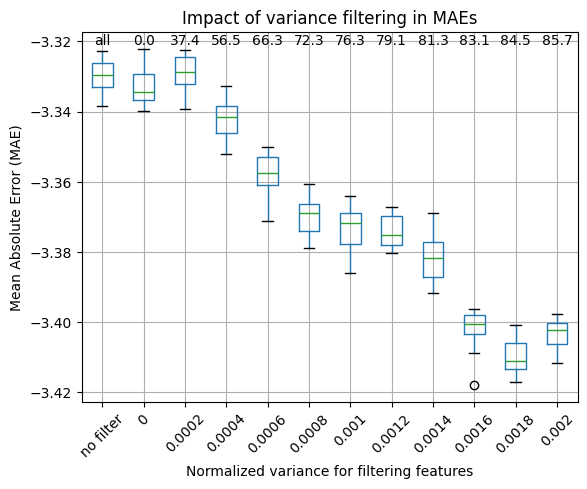

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

#Plot results 

#ADAPT THE LABELS FOR REGRESSION/CLASSIFICATION
#Plot the metrics for the cross-validation

boxplot = f1_df.boxplot();

#values is a list of percentages of low-variance features to be filtered out
labels = values#[0:6]
n_cols = len(labels)
#Height on y-axis where the lables/values should be displayed
#draw_at = 0.95835
draw_at = -3.321
for x, y, l in zip(range(1,n_cols+1), np.repeat(draw_at, n_cols),
labels):
    boxplot.text(x, y, l, horizontalalignment='center')

#Add axis labels and title
#plt.ylabel('F1 scores');
plt.ylabel('Mean Absolute Error (MAE)');
#plt.title('Impact of variance filtering in F1 scores');
plt.title('Impact of variance filtering in MAEs');
plt.xlabel('Normalized variance for filtering features');

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
ticks = plt.xticks()[0]
labels = [str(round(float(label), 1)) for label in ticks]  # Round each label to 3 decimal places

plt.savefig('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/benchmark_' + abiotic_factor + '_' + feature + '.png', 
            dpi=300, bbox_inches='tight')
print('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/benchmark_' + abiotic_factor + '_' + feature + '.png')

#Show plot
plt.show();

# Split large files

To make it possible for Correlations_total.py to be able to process large files in draco, I will split the kmer dataframes into parts, calculate the correlations, join the highly correlated features and repeat the process until all features have been properly processed.

In [6]:
#Turn off scientific notation
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})

#Activate print all activities
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [20]:
import pickle
import zstandard
import pandas as pd
import numpy as np
import datetime

print("Started script! Loading input file...", datetime.datetime.now())

feature = 'kmer9Classification'
#feature = 'kmer9Regression'
#feature = 'kmer9'

abiotic_factor = 'salt'
#abiotic_factor = 'temperature'
#abiotic_factor = 'pH'
#abiotic_factor = 'oxygen'

group = 'Salinity group'
#group = 'Salt all mean'
#group = 'Temp group'
#group = 'Temp all mean'
#group = 'pH all mean'
#group = 'Oxygen tolerance'

low_var_threshold = 0.001
n_splits = 2

file1 = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + feature + '_' + str(low_var_threshold) + '.pickle.zst'

with zstandard.open(file1, 'rb') as f:
	df = pickle.load(f)

print("Loaded input pickle zst file...", datetime.datetime.now())
df.head()
df.shape

Started script! Loading input file... 2024-07-26 09:45:14.354770
Loaded input pickle zst file... 2024-07-26 09:45:15.059454


,AAAAAAAAA,AAAAAAAAC,AAAAAAAAG,AAAAAAAAT,AAAAAAACA,AAAAAAACC,AAAAAAACG,AAAAAAACT,AAAAAAAGA,AAAAAAAGC,...,TTTCTCAAA,TTTGAAAAA,TTTGACAAA,TTTGCAAAA,TTTGCCAAA,TTTGGAAAA,TTTGTAAAA,TTTTAAAAA,TTTTCAAAA,Salinity group
Best assembly,,,,,,,,,,,,,,,,,,,,,
1051501.5,67,146,161,178,407,229,240,146,412,344,...,132,428,113,187,103,135,154,376,393,1
1077675.3,177,210,288,477,432,92,199,231,586,284,...,91,435,105,137,108,195,180,410,372,1
1121909.4,150,162,178,358,297,138,128,175,256,235,...,87,289,49,123,67,181,222,733,352,1
1123237.3,4,5,4,4,3,11,13,5,5,7,...,7,12,12,13,12,14,2,3,5,1
1123508.3,30,53,38,46,76,71,76,47,69,80,...,107,264,140,96,195,177,32,29,226,0


(1989, 33769)

In [9]:
#Step 1: Remove the last row and save it to y, keep all features separate
y = df.iloc[:, -1]
X = df.iloc[:, :-1]
X.shape

(1989, 33768)

In [13]:
#Step 2: Split the remaining columns into chunks
#X_chunks is a list with n_splits elements
X_chunks = np.array_split(X, n_splits, axis=1)

/home/bia/.local/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [19]:
len(X_chunks)
X.shape
X_chunks[0].shape
X_chunks[1].shape
#X_chunks[0].head()
#X_chunks[1].head()

2

(1989, 33768)

(1989, 16884)

(1989, 16884)

,AAAAAAAAA,AAAAAAAAC,AAAAAAAAG,AAAAAAAAT,AAAAAAACA,AAAAAAACC,AAAAAAACG,AAAAAAACT,AAAAAAAGA,AAAAAAAGC,...,CCCGCGCCC,CCCGCGCCG,CCCGCGCGA,CCCGCGCGC,CCCGCGCGG,CCCGCGCTC,CCCGCGGAC,CCCGCGGAG,CCCGCGGCA,CCCGCGGCC
Best assembly,,,,,,,,,,,,,,,,,,,,,
1051501.5,67,146,161,178,407,229,240,146,412,344,...,11,21,5,8,13,14,12,18,39,14
1077675.3,177,210,288,477,432,92,199,231,586,284,...,1,1,1,0,0,1,1,0,1,0
1121909.4,150,162,178,358,297,138,128,175,256,235,...,1,0,0,0,0,1,0,0,1,1
1123237.3,4,5,4,4,3,11,13,5,5,7,...,759,1274,585,944,980,276,85,48,184,361
1123508.3,30,53,38,46,76,71,76,47,69,80,...,231,412,169,81,293,68,93,40,91,171


,CCCGCGGCG,CCCGCGGGA,CCCGCGGGC,CCCGCGGTC,CCCGCGTAC,CCCGCGTAG,CCCGCGTCA,CCCGCGTCC,CCCGCGTCG,CCCGCGTGA,...,TTTCTAAAA,TTTCTCAAA,TTTGAAAAA,TTTGACAAA,TTTGCAAAA,TTTGCCAAA,TTTGGAAAA,TTTGTAAAA,TTTTAAAAA,TTTTCAAAA
Best assembly,,,,,,,,,,,,,,,,,,,,,
1051501.5,22,14,8,16,9,1,19,10,2,15,...,166,132,428,113,187,103,135,154,376,393
1077675.3,0,1,0,0,2,3,1,6,1,1,...,291,91,435,105,137,108,195,180,410,372
1121909.4,1,1,1,1,1,1,0,1,1,0,...,371,87,289,49,123,67,181,222,733,352
1123237.3,510,74,326,179,18,74,161,251,478,136,...,6,7,12,12,13,12,14,2,3,5
1123508.3,137,73,153,39,31,48,185,199,351,320,...,21,107,264,140,96,195,177,32,29,226


In [21]:
# Step 3: Add the removed last column to each part
for i in range(n_splits):
    X_chunks[i][group] = y

In [22]:
len(X_chunks)
X.shape
X_chunks[0].shape
X_chunks[1].shape
X_chunks[0].head()
X_chunks[1].head()

2

(1989, 33768)

(1989, 16885)

(1989, 16885)

,AAAAAAAAA,AAAAAAAAC,AAAAAAAAG,AAAAAAAAT,AAAAAAACA,AAAAAAACC,AAAAAAACG,AAAAAAACT,AAAAAAAGA,AAAAAAAGC,...,CCCGCGCCG,CCCGCGCGA,CCCGCGCGC,CCCGCGCGG,CCCGCGCTC,CCCGCGGAC,CCCGCGGAG,CCCGCGGCA,CCCGCGGCC,Salinity group
Best assembly,,,,,,,,,,,,,,,,,,,,,
1051501.5,67,146,161,178,407,229,240,146,412,344,...,21,5,8,13,14,12,18,39,14,1
1077675.3,177,210,288,477,432,92,199,231,586,284,...,1,1,0,0,1,1,0,1,0,1
1121909.4,150,162,178,358,297,138,128,175,256,235,...,0,0,0,0,1,0,0,1,1,1
1123237.3,4,5,4,4,3,11,13,5,5,7,...,1274,585,944,980,276,85,48,184,361,1
1123508.3,30,53,38,46,76,71,76,47,69,80,...,412,169,81,293,68,93,40,91,171,0


,CCCGCGGCG,CCCGCGGGA,CCCGCGGGC,CCCGCGGTC,CCCGCGTAC,CCCGCGTAG,CCCGCGTCA,CCCGCGTCC,CCCGCGTCG,CCCGCGTGA,...,TTTCTCAAA,TTTGAAAAA,TTTGACAAA,TTTGCAAAA,TTTGCCAAA,TTTGGAAAA,TTTGTAAAA,TTTTAAAAA,TTTTCAAAA,Salinity group
Best assembly,,,,,,,,,,,,,,,,,,,,,
1051501.5,22,14,8,16,9,1,19,10,2,15,...,132,428,113,187,103,135,154,376,393,1
1077675.3,0,1,0,0,2,3,1,6,1,1,...,91,435,105,137,108,195,180,410,372,1
1121909.4,1,1,1,1,1,1,0,1,1,0,...,87,289,49,123,67,181,222,733,352,1
1123237.3,510,74,326,179,18,74,161,251,478,136,...,7,12,12,13,12,14,2,3,5,1
1123508.3,137,73,153,39,31,48,185,199,351,320,...,107,264,140,96,195,177,32,29,226,0


In [23]:
#Save each DataFrame part to a separate file
for i in range(n_splits):

    file_chunk = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + feature + '_' + str(low_var_threshold) + '_chunk' + str(i) + '.pickle.zst'

    with zstandard.open(file_chunk, 'wb') as f:
        pickle.dump(X_chunks[i], f)

# Join files

To make it possible for Correlations_total.py to be able to process large files in draco, I split the kmer dataframes into parts, calculated the correlations, joined the highly correlated features. 

Now, I will join the chunks that went through Join_Features.py and repeat the process, so that all features will be properly processed.

In [14]:
#Turn off scientific notation
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})

#Activate print all activities
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [15]:
import pickle
import zstandard
import pandas as pd
import numpy as np
import datetime

print("Started script! Loading input file...", datetime.datetime.now())

feature = 'kmer9Classification'
#feature = 'kmer9Regression'
#feature = 'kmer9'

abiotic_factor = 'salt'
#abiotic_factor = 'temperature'
#abiotic_factor = 'pH'
#abiotic_factor = 'oxygen'

group = 'Salinity group'
#group = 'Salt all mean'
#group = 'Temp group'
#group = 'Temp all mean'
#group = 'pH all mean'
#group = 'Oxygen tolerance'

low_var_threshold = '0.001_chunk0joined'
low_var_threshold2 = '0.001_chunk1joined'
low_var_threshold3 = '0.001_chunkAlljoined'

file1 = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + feature + '_' + low_var_threshold + '.pickle.zst'
file2 = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + feature + '_' + low_var_threshold2 + '.pickle.zst'

file_out = '/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + feature + '_' + low_var_threshold3 + '.pickle.zst'

with zstandard.open(file1, 'rb') as f:
	df1 = pickle.load(f)

with zstandard.open(file2, 'rb') as f:
	df2 = pickle.load(f)

df1.head()
df1.shape
df2.head()
df2.shape

Started script! Loading input file... 2024-07-26 12:57:11.696314


AAAAAAAAA,AAAAAAAAC,AAAAAAAAG,AAAAAAAAT,AAAAAAACA,AAAAAAACC,AAAAAAACG,AAAAAAACT,AAAAAAAGA,AAAAAAAGC,AAAAAAAGG,AAAAAAAGT,AAAAAAATA,AAAAAAATC,AAAAAAATG,AAAAAAATT,AAAAAACAA,AAAAAACAC,AAAAAACAG,AAAAAACAT,AAAAAACCA,AAAAAACCT,AAAAAACTA,AAAAAACTT,AAAAAAGAA,AAAAAAGAC,AAAAAAGAT,AAAAAAGCA,AAAAAAGCT,AAAAAAGGA,AAAAAAGGT,AAAAAAGTA,AAAAAAGTG,AAAAAAGTT,AAAAAATAA,AAAAAATAC,AAAAAATAG,AAAAAATAT,AAAAAATCA,AAAAAATCC,AAAAAATCT,AAAAAATGA,AAAAAATGC,AAAAAATGG,AAAAAATGT,AAAAAATTA,AAAAAATTC,AAAAAATTG,AAAAAATTT,AAAAACAAA,AAAAACAAG,AAAAACAAT,AAAAACATA,AAAAACATC,AAAAACATT,AAAAACCAT,AAAAAGAAA,AAAAAGAAT,AAAAAGCAA,AAAAAGCAT,AAAAAGGAA,AAAAAGTAA,AAAAAGTAT,AAAAATAAA,AAAAATAAG,AAAAATAAT,AAAAATACA,AAAAATAGA,AAAAATATT,AAAAATCAA,AAAAATCAT,AAAAATCTT,AAAAATGAA,AAAAATGAT,AAAAATGGA,AAAAATTAA,AAAAATTAT,AAAAATTCA,AAAAATTGA,AAAAATTTA,AAAAATTTC,AAAACAAAA,AAAACAAAG,AAAAGAAAA,AAAAGAAAT,AAAAGAATA,AAAAGCAAA,AAAAGTAAA,AAAATAAAA,AAAATAAAC,AAAATAAAT,AAAATAATT,AAAATACAA,AAAATACTT,AAAATAGAA,AAAATATTT,AAAATCAAA,AAAATCAAT,AAAATGAAA,AAAATGAAT,AAAATGGAA,AAAATTAAA,AAAATTCAA,AAAATTTAA,AAACAAAAA,AAACAAAAT,AAAGAAAAA,AAAGAAAAT,AAAGCAAAA,AAAGTAAAA,AAATAAAAA,AAATAAAAC,AAATAAAAG,AAATAAAAT,AAATACAAA,AAATAGAAA,AAATCAAAA,AAATGAAAA,AAATTGAAA,AAATTTTTC,AACAAAAAA,AAGAAAAAA,AAGAAAAAT,AAGAAATAA,AAGCAAAAA,AAGTAAAAA,AATAAAAAA,AATAAAAAC,AATAAAAAG,AATAAAAAT,AATAAAATC,AATACAAAA,AATCAAAAA,AATGAAAAA,AATTAAAAA,AATTTTTAA,AATTTTTAT,AATTTTTCA,AATTTTTCT,AATTTTTTA,AATTTTTTC,AATTTTTTG,ACAAAAAAA,ACAAAAAAC,ACAAAAAAG,ACAAAAAAT,ACAATAAAA,ACCAAAAAA,ACTAAAAAA,ACTTTTTTC,ACTTTTTTG,AGAAAAAAA,AGAAAAAAC,AGAAAAAAG,AGAAAAAAT,AGAAATAAA,AGAATAAAA,AGCAAAAAA,AGGAAAAAA,AGTAAAAAA,AGTTTTTTC,ATAAAAAAA,ATAAAAAAC,ATAAAAAAG,ATAAAAAAT,ATAAAAACA,ATAAAAATC,ATAAAAATG,ATACAAAAA,ATCAAAAAA,ATGAAAAAA,ATGAAAAAT,ATTAAAAAA,ATTCAAAAA,ATTGAAAAA,ATTTTATTG,ATTTTTAAA,ATTTTTATG,ATTTTTCAA,ATTTTTGTA,ATTTTTTAA,ATTTTTTAC,ATTTTTTAG,ATTTTTTCA,ATTTTTTGA,ATTTTTTTA,ATTTTTTTC,ATTTTTTTG,CAAAAAAAA,CAAAAAAAC,CAAAAAAAG,CAAAAAACA,CAAAAAAGA,CAAAAAATA,CAAAAAATG,CAAAAACAA,CAAAAATAA,CAAAATAAA,CAAATAAAA,CAATAAAAA,CACAAAAAA,CAGAAAAAA,CATAAAAAA,CATTAAAAA,CATTTTTTA,CCAAAAAAA,CCATAAAAA  \
Best assembly                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

(1989, 2741)

CCCGCGGCG,CCCGCGGGA,CCCGCGGGC,CCCGCGGTC,CCCGCGTCC,CCCGCGTCG,CCCGCGTGC,CCCGCTCGA,CCCGCTCGC,CCCGCTCGG,CCCGCTGCG,CCCGGACGA,CCCGGACGC,CCCGGACGG,CCCGGCACG,CCCGGCCCG,CCCGGCCGA,CCCGGCCGC,CCCGGCCGG,CCCGGCCTC,CCCGGCGAC,CCCGGCGAG,CCCGGCGCC,CCCGGCGCG,CCCGGCGGA,CCCGGCGGC,CCCGGCGTC,CCCGGCTCG,CCCGGGCCG,CCCGGGCGA,CCCGGGCGC,CCCGGGCGG,CCCGGGGCG,CCCGGGTCG,CCCGGTCGA,CCCGGTCGC,CCCGGTCGG,CCCGGTGAC,CCCGGTGCG,CCCGTCACC,CCCGTCCCG,CCCGTCCGC,CCCGTCGAC,CCCGTCGAG,CCCGTCGCC,CCCGTCGCG,CCCGTCGGC,CCCGTCGTC,CCCGTGACG,CCCGTGCCG,CCCGTGCGC,CCCGTGCGG,CCCGTGCTC,CCCGTGGCG,CCCGTTCGC,CCCTCCGCG,CCCTCGACC,CCCTCGACG,CCCTCGCCC,CCCTCGCCG,CCCTCGCGC,CCCTCGCGG,CCCTCGGCC,CCCTCGGCG,CCCTCGGGC,CCCTCGGTC,CCCTCGTCC,CCCTCGTCG,CCCTCGTGC,CCCTGCTCG,CCGAACGCC,CCGAACGCG,CCGAACTCG,CCGACACCG,CCGACACGG,CCGACATCG,CCGACCACC,CCGACCACG,CCGACCAGC,CCGACCCCG,CCGACCCGA,CCGACCCGC,CCGACCCGG,CCGACCGAG,CCGACCGCA,CCGACCGCC,CCGACCGCG,CCGACCGGC,CCGACCGTC,CCGACCTCC,CCGACCTCG,CCGACCTGC,CCGACGACA,CCGACGACC,CCGACGACG,CCGACGAGA,CCGACGAGC,CCGACGAGG,CCGACGCCC,CCGACGCCG,CCGACGCGA,CCGACGCGC,CCGACGCGG,CCGACGGCA,CCGACGGCC,CCGACGGCG,CCGACGGGC,CCGACGGTC,CCGACGTCA,CCGACGTCC,CCGACGTCG,CCGACGTGA,CCGACGTGC,CCGACTGCG,CCGACTTCG,CCGAGAACG,CCGAGACCC,CCGAGACCG,CCGAGACGC,CCGAGACGG,CCGAGAGCG,CCGAGCACC,CCGAGCACG,CCGAGCAGC,CCGAGCAGG,CCGAGCCCC,CCGAGCCCG,CCGAGCCGA,CCGAGCCGC,CCGAGCCGG,CCGAGCGCA,CCGAGCGCC,CCGAGCGCG,CCGAGCGGA,CCGAGCGGC,CCGAGGACC,CCGAGGACG,CCGAGGAGC,CCGAGGCCC,CCGAGGCCG,CCGAGGCGA,CCGAGGCGC,CCGAGGCGG,CCGAGGGCA,CCGAGGGCC,CCGAGGGCG,CCGAGGGGC,CCGAGGTCC,CCGAGGTCG,CCGAGGTGA,CCGAGGTGC,CCGAGTTCG,CCGATGACG,CCGCACCCC,CCGCACCCG,CCGCACCGA,CCGCACCGC,CCGCACCGG,CCGCACCTC,CCGCACGAC,CCGCACGAG,CCGCACGCC,CCGCACGCG,CCGCACGGC,CCGCACGTC,CCGCAGCCG,CCGCAGCGA,CCGCAGCGC,CCGCAGGTC,CCGCCACCG,CCGCCACGA,CCGCCACGG,CCGCCCACC,CCGCCCACG,CCGCCCCAC,CCGCCCCCG,CCGCCCCGA,CCGCCCCGC,CCGCCCCGG,CCGCCCGAC,CCGCCCGAG,CCGCCCGCA,CCGCCCGCC,CCGCCCGCG,CCGCCCGGA,CCGCCCGGC,CCGCCCGTC,CCGCCCTCC,CCGCCCTCG,CCGCCGAAC,CCGCCGAAG,CCGCCGACC,CCGCCGACG,CCGCCGAGA,CCGCCGAGC,CCGCCGAGG,CCGCCGCAC,CCGCCGCAG,CCGCCGCCC,CCGCCGCCG,CCGCCGCGA,CCGCCGCGC,CCGCCGCGG,CCGCCGCTC,CCGCCGGAC,CCGCCGGAG,CCGCCGGCC,CCGCCGGCG,CCGCCGGGA,CCGCCGGGC,CCGCCGGTC,CCGCCGTCC,CCGCCGTCG,CCGCCGTGA,CCGCCGTGC,CCGCCTACG,CCGCCTCCG,CCGCCTCGA,CCGCCTCGC,CCGCCTTCG,CCGCGAACC,CCGCGAACG,CCGCGAAGA,CCGCGAAGG,CCGCGACAC,CCGCGACCA,CCGCGACCC,CCGCGACCG,CCGCGACGA,CCGCGACGC,CCGCGACGG,CCGCGAGAC,CCGCGAGCA,CCGCGAGCC,CCGCGAGCG,CCGCGAGGA,CCGCGAGGC,CCGCGATCG,CCGCGATGC,CCGCGCACC,CCGCGCACG,CCGCGCAGC,CCGCGCAGG,CCGCGCCCC,CCGCGCCCG,CCGCGCCGA,CCGCGCCGC,CCGCGCCGG,CCGCGCCTC,CCGCGCGAC,CCGCGCGAG,CCGCGCGCC,CCGCGCGGA,CCGCGCGGC,CCGCGCGTC,CCGCGCTCA,CCGCGCTCC,CCGCGCTCG,CCGCGCTGC,CCGCGGAAC,CCGCGGAAG,CCGCGGACA,CCGCGGACC,CCGCGGACG,CCGCGGAGC,CCGCGGAGG,CCGCGGATC,CCGCGGCAC,CCGCGGCAG,CCGCGGCCA,CCGCGGCCC,CCGCGGCCG,CCGCGGCGA,CCGCGGCGC,CCGCGGCTC,CCGCGGGAC,CCGCGGGAG,CCGCGGGCA,CCGCGGGCC,CCGCGGGCG,CCGCGGGGA,CCGCGGGGC,CCGCGGGTC,CCGCGGTCA,CCGCGGTCC,CCGCGGTCG,CCGCGGTGA,CCGCGGTGC,CCGCGGTTC,CCGCGTCAC,CCGCGTCCA,CCGCGTCCC,CCGCGTCCG,CCGCGTCGA,CCGCGTCGC,CCGCGTCTC,CCGCGTGCC,CCGCGTGCG,CCGCGTGGA,CCGCGTGGC,CCGCGTTCG,CCGCTCCGC,CCGCTCGAC,CCGCTCGCC,CCGCTCGCG,CCGCTCGGC,CCGCTCGTC,CCGCTCTCG,CCGCTGCTC,CCGGACCCG,CCGGACCGC,CCGGACGAC,CCGGACGAG,CCGGACGCC,CCGGACGCG,CCGGACGGC,CCGGAGCGC,CCGGAGGCG,CCGGAGGGC,CCGGCACCG,CCGGCACGA,CCGGCACGC,CCGGCACGG,CCGGCCACG,CCGGCCCAC,CCGGCCCCG,CCGGCCCGA,CCGGCCCGC,CCGGCCCGG,CCGGCCCTC,CCGGCCGAC,CCGGCCGAG,CCGGCCGCA,CCGGCCGCC,CCGGCCGCG,CCGGCCGTC,CCGGCCTCC,CCGGCCTCG,CCGGCGAAC,CCGGCGAAG,CCGGCGACC,CCGGCGACG,CCGGCGAGA,CCGGCGAGC,CCGGCGAGG,CCGGCGCAC,CCGGCGCCC,CCGGCGCCG,CCGGCGCGA,CCGGCGCGC,CCGGCGCTC,CCGGCGGAC,CCGGCGGAG,CCGGCGGCC,CCGGCGGCG,CCGGCGGGA,CCGGCGGGC,CCGGCGGTC,CCGGCGTCC,CCGGCGTCG,CCGGCGTGA,CCGGCGTGC,CCGGCGTTC,CCGGCTCGA,CCGGCTCGC,CCGGCTGCG,CCGGGACCG,CCGGGACGC,CCGGGACGG,CCGGGCACC,CCGGGCACG,CCGGGCCCC,CCGGGCCCG,CCGGGCCGA,CCGGGCCGC,CCGGGCCTC,CCGGGCGAC,CCGGGCGAG,CCGGGCGCC,CCGGGCGCG,CCGGGCGGA,CCGGGCGGC,CCGGGCGTC,CCGGGCTCG,CCGGGGACG,CCGGGGCCG,CCGGGGCGA,CCGGGGCGC,CCGGGGCTC,CCGGGGGCG,CCGGGGTCG,CCGGGTCCG,CCGGGTCGA,CCGGGTCGC,CCGGGTGCG,CCGGGTTCG,CCGGTCACG,CCGGTCCGC,CCGGTCGAC,CCGGTCGAG,

(1989, 2834)

In [16]:
#Remove the last row and save it to y, keep all features separate
y = df1.iloc[:, -1]
X1 = df1.iloc[:, :-1]
X2 = df2.iloc[:, :-1]

In [17]:
#Concatenate DataFrames along columns
df = pd.concat([df1, df2], axis=1)
df[group] = y
df.head()
df.shape

AAAAAAAAA,AAAAAAAAC,AAAAAAAAG,AAAAAAAAT,AAAAAAACA,AAAAAAACC,AAAAAAACG,AAAAAAACT,AAAAAAAGA,AAAAAAAGC,AAAAAAAGG,AAAAAAAGT,AAAAAAATA,AAAAAAATC,AAAAAAATG,AAAAAAATT,AAAAAACAA,AAAAAACAC,AAAAAACAG,AAAAAACAT,AAAAAACCA,AAAAAACCT,AAAAAACTA,AAAAAACTT,AAAAAAGAA,AAAAAAGAC,AAAAAAGAT,AAAAAAGCA,AAAAAAGCT,AAAAAAGGA,AAAAAAGGT,AAAAAAGTA,AAAAAAGTG,AAAAAAGTT,AAAAAATAA,AAAAAATAC,AAAAAATAG,AAAAAATAT,AAAAAATCA,AAAAAATCC,AAAAAATCT,AAAAAATGA,AAAAAATGC,AAAAAATGG,AAAAAATGT,AAAAAATTA,AAAAAATTC,AAAAAATTG,AAAAAATTT,AAAAACAAA,AAAAACAAG,AAAAACAAT,AAAAACATA,AAAAACATC,AAAAACATT,AAAAACCAT,AAAAAGAAA,AAAAAGAAT,AAAAAGCAA,AAAAAGCAT,AAAAAGGAA,AAAAAGTAA,AAAAAGTAT,AAAAATAAA,AAAAATAAG,AAAAATAAT,AAAAATACA,AAAAATAGA,AAAAATATT,AAAAATCAA,AAAAATCAT,AAAAATCTT,AAAAATGAA,AAAAATGAT,AAAAATGGA,AAAAATTAA,AAAAATTAT,AAAAATTCA,AAAAATTGA,AAAAATTTA,AAAAATTTC,AAAACAAAA,AAAACAAAG,AAAAGAAAA,AAAAGAAAT,AAAAGAATA,AAAAGCAAA,AAAAGTAAA,AAAATAAAA,AAAATAAAC,AAAATAAAT,AAAATAATT,AAAATACAA,AAAATACTT,AAAATAGAA,AAAATATTT,AAAATCAAA,AAAATCAAT,AAAATGAAA,AAAATGAAT,AAAATGGAA,AAAATTAAA,AAAATTCAA,AAAATTTAA,AAACAAAAA,AAACAAAAT,AAAGAAAAA,AAAGAAAAT,AAAGCAAAA,AAAGTAAAA,AAATAAAAA,AAATAAAAC,AAATAAAAG,AAATAAAAT,AAATACAAA,AAATAGAAA,AAATCAAAA,AAATGAAAA,AAATTGAAA,AAATTTTTC,AACAAAAAA,AAGAAAAAA,AAGAAAAAT,AAGAAATAA,AAGCAAAAA,AAGTAAAAA,AATAAAAAA,AATAAAAAC,AATAAAAAG,AATAAAAAT,AATAAAATC,AATACAAAA,AATCAAAAA,AATGAAAAA,AATTAAAAA,AATTTTTAA,AATTTTTAT,AATTTTTCA,AATTTTTCT,AATTTTTTA,AATTTTTTC,AATTTTTTG,ACAAAAAAA,ACAAAAAAC,ACAAAAAAG,ACAAAAAAT,ACAATAAAA,ACCAAAAAA,ACTAAAAAA,ACTTTTTTC,ACTTTTTTG,AGAAAAAAA,AGAAAAAAC,AGAAAAAAG,AGAAAAAAT,AGAAATAAA,AGAATAAAA,AGCAAAAAA,AGGAAAAAA,AGTAAAAAA,AGTTTTTTC,ATAAAAAAA,ATAAAAAAC,ATAAAAAAG,ATAAAAAAT,ATAAAAACA,ATAAAAATC,ATAAAAATG,ATACAAAAA,ATCAAAAAA,ATGAAAAAA,ATGAAAAAT,ATTAAAAAA,ATTCAAAAA,ATTGAAAAA,ATTTTATTG,ATTTTTAAA,ATTTTTATG,ATTTTTCAA,ATTTTTGTA,ATTTTTTAA,ATTTTTTAC,ATTTTTTAG,ATTTTTTCA,ATTTTTTGA,ATTTTTTTA,ATTTTTTTC,ATTTTTTTG,CAAAAAAAA,CAAAAAAAC,CAAAAAAAG,CAAAAAACA,CAAAAAAGA,CAAAAAATA,CAAAAAATG,CAAAAACAA,CAAAAATAA,CAAAATAAA,CAAATAAAA,CAATAAAAA,CACAAAAAA,CAGAAAAAA,CATAAAAAA,CATTAAAAA,CATTTTTTA,CCAAAAAAA,CCATAAAAA  \
Best assembly                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

(1989, 5575)

In [18]:
with zstandard.open(file_out, 'wb') as f:
    pickle.dump(df, f)